In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer,AutoModelForCausalLM, pipeline

# Doing analytics on the dataset

In [56]:
df = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Dropping useless features

In [57]:
df.drop(["Time","Id","ProductId","ProfileName","UserId"], axis=1, inplace=True)

In [58]:
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text
0,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,0,0,5,Great taffy,Great taffy at a great price. There was a wid...


## Due to limitations in computational power, we will only be using 10k lines

In [59]:
df = df.loc[:9999]

In [60]:
df.shape

(10000, 5)

## Distribution of scores

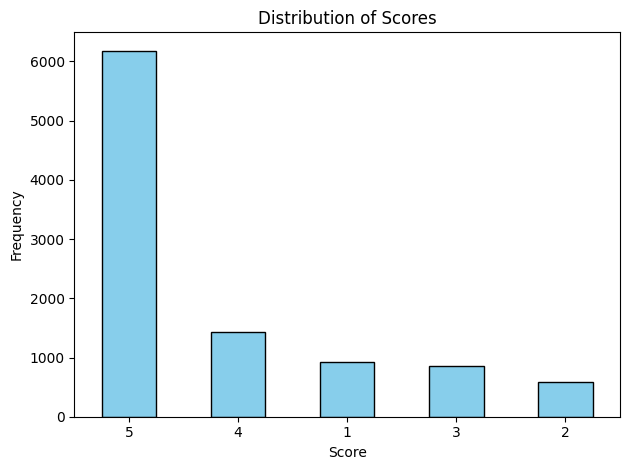

In [61]:
score_counts = df["Score"].value_counts()
score_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xticks(rotation=0) # Make x-axis labels readable
plt.tight_layout()

# Initializing the pipeline

In [ ]:
classifier = pipeline(
    task="sentiment-analysis", 
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)

# 2. Grab your RAW text (not the tokens)
# We will just use the first 5 rows to test it
texts_to_predict = df['Text'].tolist()

# 3. Run the inference
# We add truncation=True because BERT will throw an error if a review is longer than 512 words
predictions = classifier(texts_to_predict, truncation=True)


# Extract just the 'label' from each dictionary in the predictions list
predicted_labels = [result['label'] for result in predictions]

# Assign the full list of predictions to a new column for the entire dataframe
df['predicted_sentiment'] = predicted_labels

Device set to use cuda:0


## A little Test

In [ ]:
for i in range (5):
    print(df.loc[i]["Text"], df.loc[i]["Score"])

## Definition of an accuracy function to evaluate the performances

In [ ]:
def accuracy_score(groundTruth, prediction):
    total = 0
    right = 0
    
    for gScore, pScore_raw in zip(groundTruth, prediction):
        total += 1
        
        # SAFEGUARD: If your prediction is a string like '5 stars' from the Hugging Face pipeline,
        # this extracts just the integer 5. If it's already an integer, it just leaves it alone.
        pScore = int(str(pScore_raw)[0])
        
        # -- Exact Matches --
        if gScore == 5 and pScore == 5:
            right += 1
        elif gScore == 4 and pScore == 4:
            right += 1
        elif gScore == 3 and pScore == 3:
            right += 1
        elif gScore == 2 and pScore == 2:
            right += 1
        elif gScore == 1 and pScore == 1:
            right += 1
            
        # -- Relaxed "Positive" Matches --
        # Ground truth is 4, but predicted 5
        elif gScore == 4 and pScore == 5:
            right += 1
        # Ground truth is 5, but predicted 4
        elif gScore == 5 and pScore == 4:
            right += 1
            
        # -- Relaxed "Negative" Matches --
        # Ground truth is 1, but predicted 2
        elif gScore == 1 and pScore == 2:
            right += 1
        # Ground truth is 2, but predicted 1
        elif gScore == 2 and pScore == 1:
            right += 1

    # Return the final accuracy as a decimal percentage
    return right / total if total > 0 else 0.0

## Editing the output of the model in order to keep only the score

In [ ]:
df["predicted_sentiment"] = df["predicted_sentiment"].apply(func = lambda x: int(x[0]))

# Accuracy Result

In [ ]:
accuracy_score(df["Score"],df["predicted_sentiment"])